## Model Building

In [ ]:
!gdown --id '10f5vzwD6wcnv0DkUQyKQZnleeAhJX1gm' 

Downloading...
From: https://drive.google.com/uc?id=10f5vzwD6wcnv0DkUQyKQZnleeAhJX1gm
To: /content/dataset.csv
100% 63.3M/63.3M [00:00<00:00, 88.3MB/s]


### 載入所需套件

In [ ]:
!pip install catboost
import pandas as pd
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm 
from statsmodels.tools.eval_measures import rmse
import math

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


載入資料集

In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,date,tot,sbi,countPlace,countRegion,bemp,sbi_past15,bemp_past15,sbi_past30,bemp_past30,sbi_past45,bemp_past45,sbi_past60,bemp_past60,pCount_行政大樓,pCount_共同教室,pCount_鹿鳴廣場,pCount_小福,pCount_研一、大一女舍,pCount_舟山路,pCount_禮賢樓(卓聯),pCount_生命科學館,pCount_思亮館,pCount_資工所,pCount_機械系,pCount_工綜館,pCount_舊哲學系,pCount_女一舍門口,pCount_1號館,pCount_農化系,pCount_第一活動中心,pCount_文學院,pCount_網球場,pCount_化工系館,pCount_原分所,pCount_管理學院,pCount_新月台,pCount_電機二館,pCount_社會系館,pCount_圖資系,...,place_思亮館,place_新生大樓,place_新體育館,place_明達館,place_樂學館,place_水源校區,place_物理系館,place_獸醫系館,place_生命科學館,place_男八舍,place_研一、大一女舍,place_社會系館,place_禮賢樓(卓聯),place_第一活動中心,place_管理學院,place_管理學院教研館,place_總圖書館,place_舊體育館,place_行政大樓,place_計算機中心,place_農化系,place_農業陳列館,place_鄭江樓,place_電機二館,place_霖澤館,place_鹿鳴廣場,place_Ｄ區其他,region_A,region_B,region_C,region_D,region_E,sbi_15,sbi_30,sbi_45,sbi_60,rent_15,rent_30,rent_45,rent_60
0,2021/11/23,19,11,0.0,0.0,8,0.0,19.0,0.0,19.0,0.0,19.0,0.0,19.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,11.0,11.0,11.0,10.0
1,2021/11/23,10,7,0.0,0.0,3,7.0,3.0,7.0,3.0,4.0,6.0,7.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
2,2021/11/23,10,7,0.0,0.0,3,7.0,3.0,4.0,6.0,7.0,3.0,8.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
3,2021/11/23,10,7,0.0,0.0,3,4.0,6.0,7.0,3.0,8.0,2.0,8.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
4,2021/11/23,10,4,0.0,0.0,6,7.0,3.0,8.0,2.0,8.0,2.0,8.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,7.0,7.0,7.0,-3.0,-3.0,-3.0,-3.0


考量到會剩餘多少車可以借才是借車者在乎的事，主要以15分鐘後的剩餘車輛數作為預測目標，並依照日期切train & test


In [ ]:
df = df.dropna()

In [ ]:
y = df.loc[:,['sbi_15', 'sbi_30', 'sbi_45', 'sbi_60', 'rent_15', 'rent_30', 'rent_45', 'rent_60']]
X = df.drop(columns=['date', 'sbi_15', 'sbi_30', 'sbi_45', 'sbi_60', 'rent_15', 'rent_30', 'rent_45', 'rent_60'])

In [ ]:
import gc
del df
gc.collect()

115

In [ ]:
X_train = X.iloc[:71597,:]
X_test = X.iloc[71598:,:]
y_train = y.iloc[:71597]
y_test = y.iloc[71598:]

### CatBoost

In [ ]:
categorical_features_index = np.where(X_train.dtypes != float)[0]

In [ ]:
target = y_train.columns.values

In [ ]:
score = {}
for i in range(len(y.columns)):
  model = CatBoostRegressor(random_state=0,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          use_best_model=True)
  model.fit(X_train, y_train.iloc[:, i:i+1], eval_set=(X_train,y_train.iloc[:, i:i+1]), verbose=1, plot=True)
  preds = model.predict(X_test)
  result = mean_absolute_error(y_test.iloc[:, i:i+1],preds)
  # result = math.sqrt(result)
  score[target[i]] = result

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 5.9362094	test: 5.9362094	best: 5.9362094 (0)	total: 82.9ms	remaining: 1m 22s
1:	learn: 5.4536311	test: 5.4536311	best: 5.4536311 (1)	total: 121ms	remaining: 1m
2:	learn: 5.0108950	test: 5.0108950	best: 5.0108950 (2)	total: 173ms	remaining: 57.6s
3:	learn: 4.6224023	test: 4.6224023	best: 4.6224023 (3)	total: 215ms	remaining: 53.5s
4:	learn: 4.2854065	test: 4.2854065	best: 4.2854065 (4)	total: 259ms	remaining: 51.6s
5:	learn: 3.9831576	test: 3.9831576	best: 3.9831576 (5)	total: 289ms	remaining: 47.8s
6:	learn: 3.7150273	test: 3.7150273	best: 3.7150273 (6)	total: 310ms	remaining: 44s
7:	learn: 3.4821627	test: 3.4821627	best: 3.4821627 (7)	total: 343ms	remaining: 42.6s
8:	learn: 3.2786167	test: 3.2786167	best: 3.2786167 (8)	total: 370ms	remaining: 40.8s
9:	learn: 3.0991310	test: 3.0991310	best: 3.0991310 (9)	total: 389ms	remaining: 38.5s
10:	learn: 2.9422694	test: 2.9422694	best: 2.9422694 (10)	total: 405ms	remaining: 36.5s
11:	learn: 2.8084076	test

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 5.9898040	test: 5.9898040	best: 5.9898040 (0)	total: 14.4ms	remaining: 14.3s
1:	learn: 5.5593313	test: 5.5593313	best: 5.5593313 (1)	total: 28.7ms	remaining: 14.3s
2:	learn: 5.1647431	test: 5.1647431	best: 5.1647431 (2)	total: 42.1ms	remaining: 14s
3:	learn: 4.8361523	test: 4.8361523	best: 4.8361523 (3)	total: 55.5ms	remaining: 13.8s
4:	learn: 4.5387892	test: 4.5387892	best: 4.5387892 (4)	total: 69.8ms	remaining: 13.9s
5:	learn: 4.2795565	test: 4.2795565	best: 4.2795565 (5)	total: 82.3ms	remaining: 13.6s
6:	learn: 4.0457547	test: 4.0457547	best: 4.0457547 (6)	total: 99.7ms	remaining: 14.1s
7:	learn: 3.8554205	test: 3.8554205	best: 3.8554205 (7)	total: 114ms	remaining: 14.1s
8:	learn: 3.6873983	test: 3.6873983	best: 3.6873983 (8)	total: 135ms	remaining: 14.9s
9:	learn: 3.5396451	test: 3.5396451	best: 3.5396451 (9)	total: 149ms	remaining: 14.7s
10:	learn: 3.4166471	test: 3.4166471	best: 3.4166471 (10)	total: 163ms	remaining: 14.6s
11:	learn: 3.3106

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 6.0445572	test: 6.0445572	best: 6.0445572 (0)	total: 13.5ms	remaining: 13.5s
1:	learn: 5.6520934	test: 5.6520934	best: 5.6520934 (1)	total: 27.2ms	remaining: 13.6s
2:	learn: 5.2985157	test: 5.2985157	best: 5.2985157 (2)	total: 40.6ms	remaining: 13.5s
3:	learn: 4.9981794	test: 4.9981794	best: 4.9981794 (3)	total: 54.3ms	remaining: 13.5s
4:	learn: 4.7352527	test: 4.7352527	best: 4.7352527 (4)	total: 67.5ms	remaining: 13.4s
5:	learn: 4.5078204	test: 4.5078204	best: 4.5078204 (5)	total: 82.2ms	remaining: 13.6s
6:	learn: 4.3074445	test: 4.3074445	best: 4.3074445 (6)	total: 94.9ms	remaining: 13.5s
7:	learn: 4.1397546	test: 4.1397546	best: 4.1397546 (7)	total: 109ms	remaining: 13.5s
8:	learn: 3.9947973	test: 3.9947973	best: 3.9947973 (8)	total: 122ms	remaining: 13.4s
9:	learn: 3.8691491	test: 3.8691491	best: 3.8691491 (9)	total: 143ms	remaining: 14.1s
10:	learn: 3.7612571	test: 3.7612571	best: 3.7612571 (10)	total: 162ms	remaining: 14.5s
11:	learn: 3.67

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 6.0879029	test: 6.0879029	best: 6.0879029 (0)	total: 14ms	remaining: 14s
1:	learn: 5.7256864	test: 5.7256864	best: 5.7256864 (1)	total: 32.7ms	remaining: 16.3s
2:	learn: 5.4070179	test: 5.4070179	best: 5.4070179 (2)	total: 51.6ms	remaining: 17.1s
3:	learn: 5.1346032	test: 5.1346032	best: 5.1346032 (3)	total: 65.5ms	remaining: 16.3s
4:	learn: 4.9030811	test: 4.9030811	best: 4.9030811 (4)	total: 79.7ms	remaining: 15.9s
5:	learn: 4.6950577	test: 4.6950577	best: 4.6950577 (5)	total: 94.5ms	remaining: 15.7s
6:	learn: 4.5158480	test: 4.5158480	best: 4.5158480 (6)	total: 109ms	remaining: 15.4s
7:	learn: 4.3694647	test: 4.3694647	best: 4.3694647 (7)	total: 129ms	remaining: 16s
8:	learn: 4.2428122	test: 4.2428122	best: 4.2428122 (8)	total: 143ms	remaining: 15.7s
9:	learn: 4.1334109	test: 4.1334109	best: 4.1334109 (9)	total: 157ms	remaining: 15.6s
10:	learn: 4.0414173	test: 4.0414173	best: 4.0414173 (10)	total: 172ms	remaining: 15.5s
11:	learn: 3.9616711	t

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 2.1008922	test: 2.1008922	best: 2.1008922 (0)	total: 16ms	remaining: 16s
1:	learn: 2.0906137	test: 2.0906137	best: 2.0906137 (1)	total: 30.1ms	remaining: 15s
2:	learn: 2.0821035	test: 2.0821035	best: 2.0821035 (2)	total: 43.2ms	remaining: 14.3s
3:	learn: 2.0734070	test: 2.0734070	best: 2.0734070 (3)	total: 58.5ms	remaining: 14.6s
4:	learn: 2.0662868	test: 2.0662868	best: 2.0662868 (4)	total: 72.5ms	remaining: 14.4s
5:	learn: 2.0601982	test: 2.0601982	best: 2.0601982 (5)	total: 88.2ms	remaining: 14.6s
6:	learn: 2.0546311	test: 2.0546311	best: 2.0546311 (6)	total: 102ms	remaining: 14.5s
7:	learn: 2.0503899	test: 2.0503899	best: 2.0503899 (7)	total: 114ms	remaining: 14.1s
8:	learn: 2.0454959	test: 2.0454959	best: 2.0454959 (8)	total: 133ms	remaining: 14.6s
9:	learn: 2.0401055	test: 2.0401055	best: 2.0401055 (9)	total: 147ms	remaining: 14.6s
10:	learn: 2.0357760	test: 2.0357760	best: 2.0357760 (10)	total: 161ms	remaining: 14.5s
11:	learn: 2.0317788	t

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 2.8483660	test: 2.8483660	best: 2.8483660 (0)	total: 14.9ms	remaining: 14.9s
1:	learn: 2.8295245	test: 2.8295245	best: 2.8295245 (1)	total: 28.7ms	remaining: 14.3s
2:	learn: 2.8126052	test: 2.8126052	best: 2.8126052 (2)	total: 46.6ms	remaining: 15.5s
3:	learn: 2.7989443	test: 2.7989443	best: 2.7989443 (3)	total: 60.9ms	remaining: 15.2s
4:	learn: 2.7866962	test: 2.7866962	best: 2.7866962 (4)	total: 76.5ms	remaining: 15.2s
5:	learn: 2.7756770	test: 2.7756770	best: 2.7756770 (5)	total: 89.8ms	remaining: 14.9s
6:	learn: 2.7646321	test: 2.7646321	best: 2.7646321 (6)	total: 103ms	remaining: 14.7s
7:	learn: 2.7556457	test: 2.7556457	best: 2.7556457 (7)	total: 118ms	remaining: 14.6s
8:	learn: 2.7473725	test: 2.7473725	best: 2.7473725 (8)	total: 141ms	remaining: 15.5s
9:	learn: 2.7405669	test: 2.7405669	best: 2.7405669 (9)	total: 154ms	remaining: 15.3s
10:	learn: 2.7338066	test: 2.7338066	best: 2.7338066 (10)	total: 170ms	remaining: 15.3s
11:	learn: 2.727

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 3.3653886	test: 3.3653886	best: 3.3653886 (0)	total: 17ms	remaining: 17s
1:	learn: 3.3348913	test: 3.3348913	best: 3.3348913 (1)	total: 33ms	remaining: 16.5s
2:	learn: 3.3067036	test: 3.3067036	best: 3.3067036 (2)	total: 46.9ms	remaining: 15.6s
3:	learn: 3.2847719	test: 3.2847719	best: 3.2847719 (3)	total: 63.8ms	remaining: 15.9s
4:	learn: 3.2653890	test: 3.2653890	best: 3.2653890 (4)	total: 79.2ms	remaining: 15.8s
5:	learn: 3.2488718	test: 3.2488718	best: 3.2488718 (5)	total: 93.9ms	remaining: 15.6s
6:	learn: 3.2335428	test: 3.2335428	best: 3.2335428 (6)	total: 109ms	remaining: 15.4s
7:	learn: 3.2196381	test: 3.2196381	best: 3.2196381 (7)	total: 127ms	remaining: 15.8s
8:	learn: 3.2077865	test: 3.2077865	best: 3.2077865 (8)	total: 151ms	remaining: 16.6s
9:	learn: 3.1977954	test: 3.1977954	best: 3.1977954 (9)	total: 166ms	remaining: 16.4s
10:	learn: 3.1876304	test: 3.1876304	best: 3.1876304 (10)	total: 179ms	remaining: 16.1s
11:	learn: 3.1801298	t

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099567
0:	learn: 3.8033764	test: 3.8033764	best: 3.8033764 (0)	total: 16.9ms	remaining: 16.9s
1:	learn: 3.7614965	test: 3.7614965	best: 3.7614965 (1)	total: 31.2ms	remaining: 15.6s
2:	learn: 3.7263955	test: 3.7263955	best: 3.7263955 (2)	total: 45.7ms	remaining: 15.2s
3:	learn: 3.6979218	test: 3.6979218	best: 3.6979218 (3)	total: 60.9ms	remaining: 15.2s
4:	learn: 3.6714726	test: 3.6714726	best: 3.6714726 (4)	total: 75.1ms	remaining: 14.9s
5:	learn: 3.6486254	test: 3.6486254	best: 3.6486254 (5)	total: 88.8ms	remaining: 14.7s
6:	learn: 3.6278944	test: 3.6278944	best: 3.6278944 (6)	total: 103ms	remaining: 14.5s
7:	learn: 3.6096935	test: 3.6096935	best: 3.6096935 (7)	total: 127ms	remaining: 15.8s
8:	learn: 3.5941176	test: 3.5941176	best: 3.5941176 (8)	total: 148ms	remaining: 16.2s
9:	learn: 3.5817934	test: 3.5817934	best: 3.5817934 (9)	total: 161ms	remaining: 15.9s
10:	learn: 3.5680233	test: 3.5680233	best: 3.5680233 (10)	total: 175ms	remaining: 15.7s
11:	learn: 3.557

MAE

In [ ]:
score

{'rent_15': 1.0069382915314917,
 'rent_30': 1.401110445893227,
 'rent_45': 1.6729895259268157,
 'rent_60': 1.8786674421347658,
 'sbi_15': 1.0124946962370862,
 'sbi_30': 1.409151986754748,
 'sbi_45': 1.6698694470541318,
 'sbi_60': 1.8804122255818487}

Feature importance

In [ ]:
imp = model.get_feature_importance(prettified=True)
imp[0:10]

,Feature Id,Importances
0,sbi,17.235086
1,temp,6.278590
2,bemp,6.060645
3,sbi_past60,5.555284
4,sbi_past15,4.537774
5,sbi_past30,3.863253
6,sbi_past45,3.292756
7,sna_臺大大一女舍北側,2.380441
8,bemp_past60,2.314383
9,region_B,2.256181


### OLS

In [ ]:
colDf = pd.DataFrame(list(df.columns))
colDf.to_csv(baseUrl + "/data/columnName.csv", encoding="utf_8_sig")

In [ ]:
x = df.drop(columns=["date", "sbi_15", "sbi_30", "sbi_45", "sbi_60", "rent_15", "rent_30", "rent_45", "rent_60"])
y = [df["sbi_15"], df["sbi_30"], df["sbi_45"], df["sbi_60"], df["rent_15"], df["rent_30"], df["rent_45"], df["rent_60"]]

In [ ]:
toBePredicted = ["站點 15 分鐘後的剩餘車數", "站點 30 分鐘後的剩餘車數", "站點 45 分鐘後的剩餘車數", "站點 60 分鐘後的剩餘車數", "站點接下來 15 分鐘內的淨借出車數", "站點接下來 30 分鐘內的淨借出車數", "站點接下來 45 分鐘內的淨借出車數", "站點接下來 60 分鐘內的淨借出車數"]

In [ ]:
from sklearn.model_selection import train_test_split
x_train = [None] * 8
x_test = [None] * 8
y_train = [None] * 8
y_test = [None] * 8
for i in range(8):
    x_train[i], x_test[i], y_train[i], y_test[i] = train_test_split(x, y[i], test_size = 0.30, random_state = 0)

In [ ]:
for i in range(8):
    print(x_train[i].shape, y_train[i].shape, x_test[i].shape, y_test[i].shape)

(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)
(74803, 258) (74803,) (32059, 258) (32059,)


In [ ]:
maeOLS = [None] * 8
print("MAE for the OLS:")
for i in range(8):
    ols = LinearRegression(fit_intercept=True)
    ols.fit(x_train[i], y_train[i])
    y_pred = ols.predict(x_test[i])
    maeOLS[i] = mean_absolute_error(y_test[i], y_pred)
    print('predicting', toBePredicted[i], ":", maeOLS[i])

MAE for the OLS:
predicting 站點 15 分鐘後的剩餘車數 : 1.0468914308433148
predicting 站點 30 分鐘後的剩餘車數 : 1.5014371429491729
predicting 站點 45 分鐘後的剩餘車數 : 1.8133082461411405
predicting 站點 60 分鐘後的剩餘車數 : 2.0668770669347656
predicting 站點接下來 15 分鐘內的淨借出車數 : 1.0475163999043786
predicting 站點接下來 30 分鐘內的淨借出車數 : 1.5014824161564049
predicting 站點接下來 45 分鐘內的淨借出車數 : 1.8118924190355605
predicting 站點接下來 60 分鐘內的淨借出車數 : 2.0666747882624312


Plot Feature Importance

<BarContainer object of 10 artists>

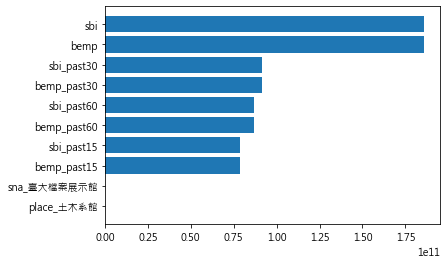

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
ols = LinearRegression(fit_intercept=True)
ols.fit(x_train[0], y_train[0])
sorted_idx = ols.coef_.argsort()
plt.barh(np.array(list(x.columns))[sorted_idx][-10:], np.array(ols.coef_)[sorted_idx][-10:])

### Decision Tree

Grid Search for `max_depth` and `min_samples_leaf`

In [ ]:
a = [None] * 8
for i in range(8):
    dt = DecisionTreeRegressor(random_state = 0)
    dt_params = {"max_depth": np.arange(1, 10, 2), "min_samples_leaf": np.arange(8, 16, 2)}
    gs_dt = GridSearchCV(dt, dt_params, cv = 3)
    gs_dt.fit(x_train[i], y_train[i])
    print("The best parameter for", toBePredicted[i], "is", gs_dt.best_params_)
    a[i] = gs_dt.best_params_

The best parameter for 站點 15 分鐘後的剩餘車數 is {'max_depth': 7, 'min_samples_leaf': 14}
The best parameter for 站點 30 分鐘後的剩餘車數 is {'max_depth': 7, 'min_samples_leaf': 12}
The best parameter for 站點 45 分鐘後的剩餘車數 is {'max_depth': 7, 'min_samples_leaf': 12}
The best parameter for 站點 60 分鐘後的剩餘車數 is {'max_depth': 9, 'min_samples_leaf': 14}
The best parameter for 站點接下來 15 分鐘內的淨借出車數 is {'max_depth': 7, 'min_samples_leaf': 14}
The best parameter for 站點接下來 30 分鐘內的淨借出車數 is {'max_depth': 9, 'min_samples_leaf': 14}
The best parameter for 站點接下來 45 分鐘內的淨借出車數 is {'max_depth': 9, 'min_samples_leaf': 14}
The best parameter for 站點接下來 60 分鐘內的淨借出車數 is {'max_depth': 9, 'min_samples_leaf': 14}


In [ ]:
a

[{'max_depth': 7, 'min_samples_leaf': 14},
 {'max_depth': 7, 'min_samples_leaf': 12},
 {'max_depth': 7, 'min_samples_leaf': 12},
 {'max_depth': 9, 'min_samples_leaf': 14},
 {'max_depth': 7, 'min_samples_leaf': 14},
 {'max_depth': 9, 'min_samples_leaf': 14},
 {'max_depth': 9, 'min_samples_leaf': 14},
 {'max_depth': 9, 'min_samples_leaf': 14}]

Predicting

In [ ]:
maeDT = [None] * 8
print("MAE for the decision tree:")
for i in range(8):
    tree = DecisionTreeRegressor(max_depth = a[i]["max_depth"], min_samples_leaf = a[i]["min_samples_leaf"])
    model = tree.fit(x_train[i], y_train[i])
    y_pred = model.predict(x_test[i])
    maeDT[i] = mean_absolute_error(y_test[i], y_pred)
    print('predicting', toBePredicted[i], ":", maeDT[i])

MAE for the decision tree:
predicting 站點 15 分鐘後的剩餘車數 : 1.0518305515344268
predicting 站點 30 分鐘後的剩餘車數 : 1.5116350360749566
predicting 站點 45 分鐘後的剩餘車數 : 1.823464432055842
predicting 站點 60 分鐘後的剩餘車數 : 2.0520843289869393
predicting 站點接下來 15 分鐘內的淨借出車數 : 1.038753040947829
predicting 站點接下來 30 分鐘內的淨借出車數 : 1.4622373528716963
predicting 站點接下來 45 分鐘內的淨借出車數 : 1.7994061853074617
predicting 站點接下來 60 分鐘內的淨借出車數 : 2.030754474098408


Plot Feature Importance

<BarContainer object of 10 artists>

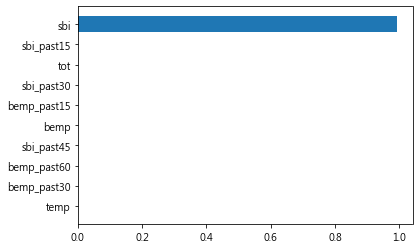

In [ ]:
tree = DecisionTreeRegressor(max_depth = a[0]["max_depth"], min_samples_leaf = a[0]["min_samples_leaf"])
model = tree.fit(x_train[0], y_train[0])
sorted_idx = tree.feature_importances_.argsort()
plt.barh(np.array(list(x.columns))[sorted_idx][-10:], np.array(tree.feature_importances_)[sorted_idx][-10:])

### Random Forest

Grid Search for `n_estimators`

In [ ]:
b = [None] * 8
for i in range(8):
    rf = RandomForestRegressor(max_depth = a[i]["max_depth"], min_samples_leaf = a[i]["min_samples_leaf"], random_state = 0)
    rf_params = {"n_estimators": np.arange(60, 90, 10)}
    gs_rf = GridSearchCV(rf, rf_params, cv = 3)
    gs_rf.fit(x_train[i], y_train[i])
    print("The best parameter for", toBePredicted[i], "is", gs_rf.best_params_)
    b[i] = gs_rf.best_params_

The best parameter for 站點 15 分鐘後的剩餘車數 is {'n_estimators': 60}
The best parameter for 站點 30 分鐘後的剩餘車數 is {'n_estimators': 70}
The best parameter for 站點 45 分鐘後的剩餘車數 is {'n_estimators': 80}
The best parameter for 站點 60 分鐘後的剩餘車數 is {'n_estimators': 80}
The best parameter for 站點接下來 15 分鐘內的淨借出車數 is {'n_estimators': 60}
The best parameter for 站點接下來 30 分鐘內的淨借出車數 is {'n_estimators': 80}
The best parameter for 站點接下來 45 分鐘內的淨借出車數 is {'n_estimators': 70}
The best parameter for 站點接下來 60 分鐘內的淨借出車數 is {'n_estimators': 60}


In [ ]:
b

[{'n_estimators': 60},
 {'n_estimators': 70},
 {'n_estimators': 80},
 {'n_estimators': 80},
 {'n_estimators': 60},
 {'n_estimators': 80},
 {'n_estimators': 70},
 {'n_estimators': 60}]

Predicting

In [ ]:
maeRF = [None] * 8
print('MAE for the random forest:')
for i in range(8):
    forest = RandomForestRegressor(n_estimators = b[i]['n_estimators'], max_depth = a[i]['max_depth'], min_samples_leaf = a[i]['min_samples_leaf'], random_state = 0)
    model = forest.fit(x_train[i], y_train[i])
    y_pred = model.predict(x_test[i])
    maeRF[i] = mean_absolute_error(y_test[i], y_pred)
    print('predicting', toBePredicted[i], ":", maeRF[i])

MAE for the random forest:
predicting 站點 15 分鐘後的剩餘車數 : 1.0410497714235876
predicting 站點 30 分鐘後的剩餘車數 : 1.4777694364018548
predicting 站點 45 分鐘後的剩餘車數 : 1.7886560308357218
predicting 站點 60 分鐘後的剩餘車數 : 1.9987304907226866
predicting 站點接下來 15 分鐘內的淨借出車數 : 1.020902799175414
predicting 站點接下來 30 分鐘內的淨借出車數 : 1.4412598558416179
predicting 站點接下來 45 分鐘內的淨借出車數 : 1.7501740836849682
predicting 站點接下來 60 分鐘內的淨借出車數 : 1.978312401596131


Plot Feature Importance

<BarContainer object of 10 artists>

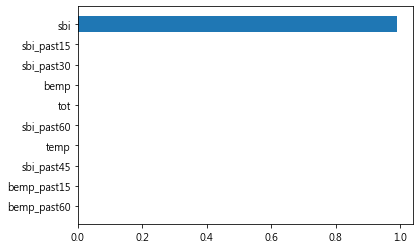

In [ ]:
forest = RandomForestRegressor(
    n_estimators = b[0]["n_estimators"],
    max_depth = a[0]["max_depth"], 
    min_samples_leaf = a[0]["min_samples_leaf"], 
    random_state = 0)
model = forest.fit(x_train[0], y_train[0])
sorted_idx = forest.feature_importances_.argsort()
plt.barh(np.array(list(x.columns))[sorted_idx][-10:], np.array(forest.feature_importances_)[sorted_idx][-10:])

### MLP

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(258, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 1)
    )
    
  def forward(self, x):
    return self.layers(x).flatten()


DF to numpy

In [ ]:
X_train = X_res.to_numpy()
y_train = y_res.to_numpy()
X_test = X_test.to_numpy()

In [ ]:
score = {}
trainingRMSE = []
batch = []
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
for i in range(len(y_res.columns)):  
  torch_dataset = Data.TensorDataset(X_train, y_train[:, i])

  model = MLP()
  lossFunction = nn.MSELoss(size_average=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  minibatch = 1000

  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=minibatch,
      shuffle=True,
      num_workers=0
  )

  trainResult = []
  valResult = []
  countDontChange = 0
  bestValidRMSE = 3000
  totalBatch = 0
  totalBatch2 = 0
  for epoch in range(130):
    train_loss = 0
    size = len(loader.dataset)
    model.train()
    for step, (batch_x, batch_y) in enumerate(loader):
      batch_y = batch_y.float()
      output = model(batch_x.float()) 
      loss = lossFunction(output, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step % 100 == 0:
        totalBatch += 100
        temp = batch_y.detach().numpy() - output.detach().numpy()
        leng = len(temp)
        temp = np.sum(temp**2)
        temp = temp / leng
        trainRMSE = math.sqrt(temp)
        trainResult.append(trainRMSE)
        current = step * len(batch_x)
        if i==0:
          batch.append(totalBatch)
          trainingRMSE.append(trainRMSE)

        print(f"Batch:{totalBatch} Training RMSE: {trainRMSE} [{current:>5d}/{size:>5d}]")
    result = model(X_test.float())
  result = result.detach().numpy()
  temp = result - y_test.iloc[:, i]
  leng = len(temp)
  temp = np.sum(np.abs(temp))
  testRMSE = temp / leng
  print(f"MAE:{testRMSE}")
  score[target[i]] = testRMSE


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Batch:100 Training RMSE: 32.12587839266033 [    0/1569210]
Batch:200 Training RMSE: 27.16489002370523 [100000/1569210]
Batch:300 Training RMSE: 6.699881353893515 [200000/1569210]
Batch:400 Training RMSE: 4.768199919125665 [300000/1569210]
Batch:500 Training RMSE: 3.5555612250388826 [400000/1569210]
Batch:600 Training RMSE: 3.505490113735881 [500000/1569210]
Batch:700 Training RMSE: 3.1973738002851655 [600000/1569210]
Batch:800 Training RMSE: 3.612855329626762 [700000/1569210]
Batch:900 Training RMSE: 3.7534187541160393 [800000/1569210]
Batch:1000 Training RMSE: 3.3153154308828596 [900000/1569210]
Batch:1100 Training RMSE: 3.162404272266593 [1000000/1569210]
Batch:1200 Training RMSE: 3.2007067090722323 [1100000/1569210]
Batch:1300 Training RMSE: 3.2273776966563736 [1200000/1569210]
Batch:1400 Training RMSE: 3.483591139408082 [1300000/1569210]
Batch:1500 Training RMSE: 2.98477369719004 [1400000/1569210]
Batch:1600 Training RMSE: 2.8449260960853624 [1500000/1569210]
Batch:1700 Training RM

In [ ]:
score

{'sbi_15': 1.221160917583335}

### Deal with Imbalanced Data - SMOTE

In [ ]:
x_train_resampled, y_train_resampled = SMOTE(k_neighbors = 2, random_state = 0).fit_resample(x_train[0], y_train[0])
print(sorted(Counter(y_train_resampled).items()))

[(0.0, 29410), (1.0, 29410), (2.0, 29410), (3.0, 29410), (4.0, 29410), (5.0, 29410), (6.0, 29410), (7.0, 29410), (8.0, 29410), (9.0, 29410), (10.0, 29410), (11.0, 29410), (12.0, 29410), (13.0, 29410), (14.0, 29410), (15.0, 29410), (16.0, 29410), (17.0, 29410), (18.0, 29410), (19.0, 29410), (20.0, 29410), (21.0, 29410), (22.0, 29410), (23.0, 29410), (24.0, 29410), (25.0, 29410), (26.0, 29410), (27.0, 29410), (28.0, 29410), (29.0, 29410), (30.0, 29410), (31.0, 29410), (32.0, 29410), (33.0, 29410), (34.0, 29410), (35.0, 29410), (36.0, 29410), (37.0, 29410), (38.0, 29410), (39.0, 29410), (40.0, 29410), (41.0, 29410), (42.0, 29410), (43.0, 29410), (44.0, 29410), (45.0, 29410), (46.0, 29410), (47.0, 29410), (48.0, 29410), (49.0, 29410), (50.0, 29410), (51.0, 29410), (52.0, 29410), (53.0, 29410), (54.0, 29410), (55.0, 29410), (56.0, 29410)]


In [ ]:
x_train_resampled.shape, y_train_resampled.shape

((1676370, 258), (1676370,))

#### OLS

In [ ]:
ols = LinearRegression(fit_intercept=True)
ols.fit(x_train_resampled, y_train_resampled)
y_pred = ols.predict(x_test[0])
maeOLS_smote = mean_absolute_error(y_test[0], y_pred)
print("MAE for OLS with SMOTE:", maeOLS_smote)

MAE for OLS with SMOTE: 1.7600834377871322


#### Decision Tree

In [ ]:
dt = DecisionTreeRegressor(random_state = 0)
dt_params = {"max_depth": np.arange(1, 10, 2), "min_samples_leaf": np.arange(8, 16, 2)}
gs_dt = GridSearchCV(dt, dt_params, cv = 3)
gs_dt.fit(x_train_resampled, y_train_resampled)
print("The best parameter is", gs_dt.best_params_)
a = gs_dt.best_params_
tree = DecisionTreeRegressor(max_depth = a["max_depth"], min_samples_leaf = a["min_samples_leaf"])
model = tree.fit(x_train_resampled, y_train_resampled)
y_pred = model.predict(x_test[0])
maeDT_smote = mean_absolute_error(y_test[0], y_pred)
print("MAE for Decision Tree with SMOTE:", maeDT_smote)

The best parameter is {'max_depth': 9, 'min_samples_leaf': 14}
MAE for Decision Tree with SMOTE: 1.921681366499413


#### Random Forest

In [ ]:
rf = RandomForestRegressor(max_depth = 9, min_samples_leaf = 14, random_state = 0)
rf_params = {"n_estimators": np.arange(60, 90, 10)}
gs_rf = GridSearchCV(rf, rf_params, cv = 3)
gs_rf.fit(x_train_resampled, y_train_resampled)
print("The best parameter is", gs_rf.best_params_)
b = gs_rf.best_params_
forest = RandomForestRegressor(n_estimators = b['n_estimators'], max_depth = 9, min_samples_leaf = 14, random_state = 0)
model = forest.fit(x_train_resampled, y_train_resampled)
y_pred = model.predict(x_test[0])
maeRF_smote = mean_absolute_error(y_test[0], y_pred)
print("MAE for Random Forest with SMOTE:", maeRF_smote)

The best parameter is {'n_estimators': 80}
MAE for Random Forest with SMOTE: 1.9084882924789321


#### CatBoost

In [ ]:
sm = SMOTE(random_state=0, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
categorical_features_index = np.where(X_res.dtypes != float)[0]

In [ ]:
target = y_res.columns.values

In [ ]:
score = {}
for i in range(len(y_res.columns)):
  model = CatBoostRegressor(random_state=0,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          use_best_model=True)
  model.fit(X_res, y_res.iloc[:, i:i+1], eval_set=(X_res, y_res.iloc[:, i:i+1]), verbose=1, plot=True)
  preds = model.predict(X_test)
  result = mean_absolute_error(y_test.iloc[:, i:i+1],preds)
  # result = math.sqrt(result)
  score[target[i]] = result

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.161666
0:	learn: 14.0025703	test: 14.0025703	best: 14.0025703 (0)	total: 513ms	remaining: 8m 32s
1:	learn: 11.9624266	test: 11.9624266	best: 11.9624266 (1)	total: 904ms	remaining: 7m 31s
2:	learn: 10.2594803	test: 10.2594803	best: 10.2594803 (2)	total: 1.29s	remaining: 7m 9s
3:	learn: 8.8662113	test: 8.8662113	best: 8.8662113 (3)	total: 1.68s	remaining: 6m 57s
4:	learn: 7.7076809	test: 7.7076809	best: 7.7076809 (4)	total: 2.06s	remaining: 6m 50s
5:	learn: 6.7563059	test: 6.7563059	best: 6.7563059 (5)	total: 2.44s	remaining: 6m 44s
6:	learn: 5.9779484	test: 5.9779484	best: 5.9779484 (6)	total: 2.82s	remaining: 6m 40s
7:	learn: 5.3556957	test: 5.3556957	best: 5.3556957 (7)	total: 3.22s	remaining: 6m 39s
8:	learn: 4.8538356	test: 4.8538356	best: 4.8538356 (8)	total: 3.57s	remaining: 6m 32s
9:	learn: 4.4585517	test: 4.4585517	best: 4.4585517 (9)	total: 3.91s	remaining: 6m 27s
10:	learn: 4.1497099	test: 4.1497099	best: 4.1497099 (10)	total: 4.25s	remaining: 6m 22s
11:

MAE

In [ ]:
score

{'sbi_15': 1.3248733725123945}

### Fine tuning

#### MLP

讓模型簡單一點時效果最好

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(258, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
    )
    
  def forward(self, x):
    return self.layers(x).flatten()


In [ ]:
score = {}
trainingRMSE = []
batch = []
# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train)
# X_test = torch.from_numpy(X_test)
for i in range(len(y.columns)):  
  torch_dataset = Data.TensorDataset(X_train, y_train[:, i])

  model = MLP()
  lossFunction = nn.MSELoss(size_average=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  minibatch = 1000

  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=minibatch,
      shuffle=True,
      num_workers=0
  )

  trainResult = []
  valResult = []
  countDontChange = 0
  bestValidRMSE = 3000
  totalBatch = 0
  totalBatch2 = 0
  for epoch in range(130):
    train_loss = 0
    size = len(loader.dataset)
    model.train()
    for step, (batch_x, batch_y) in enumerate(loader):
      batch_y = batch_y.float()
      output = model(batch_x.float()) 
      loss = lossFunction(output, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step % 100 == 0:
        totalBatch += 100
        temp = batch_y.detach().numpy() - output.detach().numpy()
        leng = len(temp)
        temp = np.sum(temp**2)
        temp = temp / leng
        trainRMSE = math.sqrt(temp)
        trainResult.append(trainRMSE)
        current = step * len(batch_x)
        if i==0:
          batch.append(totalBatch)
          trainingRMSE.append(trainRMSE)
        print(f"Batch:{totalBatch} Training RMSE: {trainRMSE} [{current:>5d}/{size:>5d}]")
    result = model(X_test.float())
  result = result.detach().numpy()
  temp = result - y_test.iloc[:, i]
  leng = len(temp)
  temp = np.sum(np.abs(temp))
  testRMSE = temp / leng
  print(f"Test MAE:{testRMSE}")
  score[target[i]] = testRMSE


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Batch:100 Training RMSE: 8.38496608520273 [    0/71597]
Batch:200 Training RMSE: 6.169330963017789 [    0/71597]
Batch:300 Training RMSE: 4.5623724297233785 [    0/71597]
Batch:400 Training RMSE: 2.9615616921229244 [    0/71597]
Batch:500 Training RMSE: 2.344669611253897 [    0/71597]
Batch:600 Training RMSE: 2.6823693758969887 [    0/71597]
Batch:700 Training RMSE: 2.377698097359608 [    0/71597]
Batch:800 Training RMSE: 2.3643416267800643 [    0/71597]
Batch:900 Training RMSE: 2.118761292374037 [    0/71597]
Batch:1000 Training RMSE: 2.0806903808441803 [    0/71597]
Batch:1100 Training RMSE: 1.9483906369665067 [    0/71597]
Batch:1200 Training RMSE: 2.025515462943939 [    0/71597]
Batch:1300 Training RMSE: 1.9898380754237894 [    0/71597]
Batch:1400 Training RMSE: 2.2919643509307686 [    0/71597]
Batch:1500 Training RMSE: 1.836380664598846 [    0/71597]
Batch:1600 Training RMSE: 1.8708434396766742 [    0/71597]
Batch:1700 Training RMSE: 2.1436385038425323 [    0/71597]
Batch:1800 Tra

In [ ]:
score

{'rent_15': 1.0575437363642377,
 'rent_30': 1.4082023487293234,
 'rent_45': 1.6358947924348,
 'rent_60': 1.7836424941742668,
 'sbi_15': 1.0340871323933638,
 'sbi_30': 1.4218336912254446,
 'sbi_45': 1.6587026373271117,
 'sbi_60': 1.8125604392886507}

#### Random Search for `max_depth`, `min_samples_leaf`, `n_estimators`

In [ ]:
param = [None] * 8
for i in range(8):
    rf = RandomForestRegressor(random_state = 0)
    rs_params = {
        "max_depth": np.arange(1, 50, 5),
        "min_samples_leaf": np.arange(1, 20, 2), 
        "n_estimators": np.arange(50, 150, 25)
    }
    rs_rf = RandomizedSearchCV(rf, rs_params, cv = 3, n_iter = 10)
    rs_rf.fit(x_train[i], y_train[i])
    param[i] = rs_rf.best_params_

In [ ]:
param

[{'n_estimators': 125, 'min_samples_leaf': 3, 'max_depth': 26},
 {'n_estimators': 75, 'min_samples_leaf': 3, 'max_depth': 36},
 {'n_estimators': 75, 'min_samples_leaf': 1, 'max_depth': 26},
 {'n_estimators': 75, 'min_samples_leaf': 5, 'max_depth': 21},
 {'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 21},
 {'n_estimators': 75, 'min_samples_leaf': 3, 'max_depth': 31},
 {'n_estimators': 75, 'min_samples_leaf': 3, 'max_depth': 31},
 {'n_estimators': 75, 'min_samples_leaf': 5, 'max_depth': 21}]

Predicting

In [ ]:
maeRF_RS = [None] * 8

In [ ]:
for i in range(8):
    forest = RandomForestRegressor(
        random_state = 0, 
        max_depth = rs_rf.best_params_["max_depth"], 
        min_samples_leaf = rs_rf.best_params_["min_samples_leaf"],
        n_estimators = rs_rf.best_params_["n_estimators"]
    )
    model = forest.fit(x_train[i], y_train[i])
    y_pred = model.predict(x_test[i])
    maeRF_RS[i] = mean_absolute_error(y_test[i], y_pred)
    print("MAE of predicting", toBePredicted[i], ":", maeRF_RS[i])

MAE of predicting 站點 15 分鐘後的剩餘車數 : 1.0141420208574718
MAE of predicting 站點 30 分鐘後的剩餘車數 : 1.3918196962809994
MAE of predicting 站點 45 分鐘後的剩餘車數 : 1.6292050683494668
MAE of predicting 站點 60 分鐘後的剩餘車數 : 1.866213186466144
MAE of predicting 站點接下來 15 分鐘內的淨借出車數 : 0.9824604040252743
MAE of predicting 站點接下來 30 分鐘內的淨借出車數 : 1.3421769184643657
MAE of predicting 站點接下來 45 分鐘內的淨借出車數 : 1.576484923330161
MAE of predicting 站點接下來 60 分鐘內的淨借出車數 : 1.821297300877259
